# Birdwatching predictor based on weather patterns

**Author**: Patrick Gilles



## Table of Contents

1. [Setup and Data Exploration](#part1)

<a id='part1'></a>
## Part 1: Setup and Data Exploration 

Setup complete.
Dataset loaded successfully.
611785 tracks available for the assignment.
611785 tracks available for the assignment.
Unique species: 270
Filtered species: 149


common_name
Connecticut Warbler     1
Indian Peafowl          1
Sandhill Crane          1
Brewer's Blackbird      1
Ring-necked Pheasant    1
Name: count, dtype: int64

common_name
Lesser Yellowlegs      231
Lesser Scaup           217
Veery                  213
American Black Duck    205
Common Nighthawk       204
Name: count, dtype: int64


Sample stuff from the dataset (showing all features):


,checklist_id,common_name,observation_count,observation_date
0,G10000438,Spotted Sandpiper,1,2023-04-15
1,G10000438,Red-winged Blackbird,5,2023-04-15
2,G10000438,Mallard,5,2023-04-15
3,G10000438,Green Heron,2,2023-04-15
4,G10000438,Northern Cardinal,3,2023-04-15


,checklist_id,common_name,observation_count,observation_date
0,G10000438,Spotted Sandpiper,1,2023-04-15
1,G10000438,Red-winged Blackbird,5,2023-04-15
2,G10000438,Mallard,5,2023-04-15
3,G10000438,Green Heron,2,2023-04-15
4,G10000438,Northern Cardinal,3,2023-04-15


checklist_id             G10000438
common_name          American Crow
observation_count                2
observation_date        2023-04-15
Name: 5, dtype: object


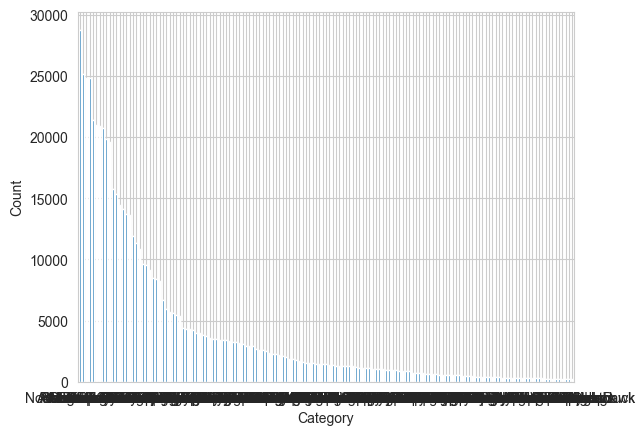

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Audio
import subprocess
import atexit
import sklearn

# Configure libraries
pd.set_option('display.max_columns', 50)
sns.set_style("whitegrid")
np.random.seed(42) # for reproducibility

print("Setup complete.")

# --- Data Loading ---
try:
    observations_df = pd.read_csv('data/observations-minimal.csv')
    print("Dataset loaded successfully.")
    print(f"{len(observations_df)} tracks available for the assignment.")
    observations_df.dropna(subset=['checklist_id', 'common_name', 'observation_count', 'observation_date'], inplace=True)
    print(f"{len(observations_df)} tracks available for the assignment.")
except FileNotFoundError:
    print("ERROR: Make sure you have the 'data' folder with 'mergedFile.csv' in your project root.")

observation_columns = ['checklist_id', 'common_name', 'observation_count', 'observation_date']
print(f'Unique species: {observations_df["common_name"].unique().size}')

# Create a bar plot to visualize the frequency of each category
species_counts = observations_df['common_name'].value_counts()
species_counts.plot(kind='bar', xlabel='Category', ylabel='Count', rot=0)

# remove birds which are rare. These will only contribute to overfitting, as their relation to weater and date is probably coincidental
filtered_counts = species_counts[species_counts > 200]
filtered_counts.plot(kind='bar', xlabel='Category', ylabel='Count', rot=0)
print(f'Filtered species: {filtered_counts.size}')
filtered_df = observations_df[observations_df['common_name'].isin(filtered_counts.index.values)]

# egrets = observations_df[observations_df['common_name'].str.contains("Egret", case=False)]
# egrets_count = egrets['common_name'].value_counts()
# display(egrets_count)

display(species_counts.tail())
display(filtered_counts.tail())
print("\nSample stuff from the dataset (showing all features):")
display(observations_df.head())
display(filtered_df.head())
print(filtered_df.iloc[5])

In [3]:
# --- Data Loading 2---
try:
    raw_weather_df = pd.read_csv('data/Weather data -- 4127258.csv')
    print("Dataset loaded successfully.")
    print(f"{len(raw_weather_df)} tracks available for the assignment.")
    # weather_df.dropna(subset=['PRCP'], inplace=True)
    # print(f"{len(weather_df)} tracks available for the assignment.")
except FileNotFoundError:
    print("ERROR: Make sure you have the 'data' folder with 'mergedFile.csv' in your project root.")

weather_columns = ['DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT06', 'WT11']

display(raw_weather_df.head())
print(raw_weather_df.iloc[0]['DATE'])

Dataset loaded successfully.
11398 tracks available for the assignment.


,STATION,NAME,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00446999,"RADFORD 3 N, VA US",1/1/2010,NaN,NaN,0.02,0.0,1.0,37.0,28.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00446999,"RADFORD 3 N, VA US",1/2/2010,NaN,NaN,0.00,0.0,1.0,36.0,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00446999,"RADFORD 3 N, VA US",1/3/2010,NaN,NaN,0.00,0.0,1.0,19.0,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00446999,"RADFORD 3 N, VA US",1/4/2010,NaN,NaN,0.00,0.0,1.0,19.0,9.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00446999,"RADFORD 3 N, VA US",1/5/2010,NaN,NaN,0.00,0.0,1.0,22.0,10.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1/1/2010


### Bird output format

In [4]:

# Get list of possible birds
# names = observations_df['common_name'].unique()
names = filtered_counts.index.values
# print(names)

# Get total checklists per day
try:
    checklists_df = pd.read_csv('data/checklists-id_date.csv')
except FileNotFoundError:
    print("ERROR: File not found.")

display(checklists_df.head())
checklists_count = checklists_df['observation_date'].value_counts()
# checklists_count.plot(kind='bar', xlabel='Category', ylabel='Count', rot=0)
display(checklists_count.tail())
dates = checklists_count.index.values


# Count how many checklists per day each bird appears in
dailys_df = pd.DataFrame(np.zeros((checklists_count.size, names.size)), columns=names)
dailys_df['date'] = checklists_count.index.values
# display(dailys_df.head())
# display(filtered_df.head())

dailys_df = dailys_df.sort_values(by='date')
print('first sort done')
filtered_df = filtered_df.sort_values(by='observation_date')
print('second sort done')
print(len(filtered_df))

# this code proves that for any checklist, a bird will only appear on it once
# count = 0
# balh = set()
# for index,row in filtered_df.iterrows():
#     count += 1 
#     if (row['common_name'], row['checklist_id']) in balh:
#         print(sus)
#     else:
#         balh.add((row['common_name'], row['checklist_id']))
#     if count % 10000 == 0:
#         print( count // 10000, innercount)
# print('sussing done')

count = 0
innercount = 0
date = ""
temprow = np.zeros((1,names.size))
for index,row in filtered_df.iterrows():
    if row['observation_date'] != date:
        innercount += 1
        if count != 0:
            dailys_df.loc[dailys_df['date'] == date] = temprow.values
            # debug to check if a species has more observations than the checklist
            # print(temprow.drop('date',axis=1).max(axis=1))
            # print(dailys_df.loc[dailys_df['date'] == date])
            # if count > 1000:
            #     break
        temprow = pd.DataFrame(np.zeros((1, names.size)), columns=names)
        temprow['date'] = row['observation_date']
        date = row['observation_date']
    
    temprow[row['common_name']] += 1.0 / checklists_count.loc[date]
    # temprow[row['common_name']] += 1
    
    # dailys_df.loc[dailys_df['date'] == row['observation_date'], row['common_name']] += 1
    count += 1
    if count % 10000 == 0:
        print( count // 10000, innercount)

display(dailys_df.head())
# for index,row in dailys_df.iterrows():
#     if sum(row.drop('date')) != 0:
#         print(row)
      
# Divide by total per that day

,checklist_id,observation_date
0,S67937133,2020-04-27
1,S68045064,2020-04-29
2,S68006668,2020-04-28
3,S66402855,2020-03-30
4,S67691101,2020-04-23


observation_date
2015-06-25    1
2015-09-29    1
2015-12-03    1
2015-01-27    1
2014-12-01    1
Name: count, dtype: int64

first sort done
second sort done
605344
1 234
2 457
3 633
4 777
5 832
6 944
7 1066
8 1170
9 1273
10 1426
11 1513
12 1556
13 1650
14 1745
15 1856
16 1901
17 1960
18 2047
19 2153
20 2234
21 2259
22 2276
23 2321
24 2395
25 2447
26 2517
27 2567
28 2605
29 2633
30 2693
31 2772
32 2854
33 2916
34 2953
35 2981
36 3000
37 3067
38 3131
39 3188
40 3282
41 3330
42 3359
43 3382
44 3451
45 3501
46 3550
47 3615
48 3668
49 3704
50 3723
51 3744
52 3801
53 3867
54 3907
55 3970
56 4020
57 4062
58 4083
59 4101
60 4166


,Northern Cardinal,American Crow,Song Sparrow,Blue Jay,Carolina Wren,Mourning Dove,American Goldfinch,American Robin,Tufted Titmouse,Carolina Chickadee,European Starling,Red-bellied Woodpecker,House Finch,White-breasted Nuthatch,Eastern Towhee,Downy Woodpecker,Northern Mockingbird,Eastern Bluebird,White-throated Sparrow,Canada Goose,Gray Catbird,Mallard,Red-winged Blackbird,Common Grackle,Turkey Vulture,...,Blackburnian Warbler,Great Horned Owl,Muscovy Duck,Fish Crow,Red-headed Woodpecker,Green-winged Teal,Common Merganser,Rusty Blackbird,Yellow-throated Warbler,Ring-necked Duck,Northern Shoveler,Prairie Warbler,American Barn Owl,American Coot,Grasshopper Sparrow,Least Sandpiper,Barred Owl,American Woodcock,American Wigeon,Lesser Yellowlegs,Lesser Scaup,Veery,American Black Duck,Common Nighthawk,date
3450,0.500000,0.750000,0.750000,0.500000,0.500000,0.500000,0.750000,0.250000,1.000000,0.750000,0.750000,0.750000,0.500000,0.500000,0.000000,0.750000,0.25,0.250000,0.500000,0.00,0.0,0.000000,0.0,0.0,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-01
3054,0.666667,1.000000,0.333333,0.833333,0.500000,0.500000,0.666667,0.333333,0.666667,0.666667,0.166667,0.666667,0.500000,0.666667,0.166667,0.500000,0.50,0.333333,0.666667,0.00,0.0,0.333333,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-02
3744,0.333333,0.666667,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.333333,0.00,0.000000,0.333333,0.00,0.0,0.333333,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-03
3728,0.333333,0.666667,1.000000,0.333333,0.333333,0.333333,0.333333,0.000000,0.666667,0.666667,0.666667,0.333333,0.333333,1.000000,0.000000,1.000000,0.00,0.000000,0.666667,0.00,0.0,0.000000,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-04
2386,0.500000,0.750000,0.375000,0.750000,0.500000,0.375000,0.250000,0.250000,0.500000,0.250000,0.250000,0.500000,0.250000,0.625000,0.000000,0.625000,0.25,0.125000,0.500000,0.25,0.0,0.375000,0.0,0.0,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-05


In [8]:
from datetime import datetime, date

for index,row in raw_weather_df.iterrows():
    raw_weather_df.loc[raw_weather_df['DATE'] == row['DATE'],'DATE'] = datetime.strptime(row['DATE'], "%m/%d/%Y").strftime("%Y-%m-%d")
display(raw_weather_df.head())
weather_df = raw_weather_df[raw_weather_df['STATION'] == 'USC00440766']
weather_df = weather_df[weather_columns]
weather_df = weather_df[weather_df['DATE'].isin(checklists_count.index.values)]
display(weather_df.head())
print(len(weather_df),len(dailys_df))

sdailys_df = dailys_df.iloc[:-7]
print(len(weather_df),len(sdailys_df))

,STATION,NAME,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00446999,"RADFORD 3 N, VA US",2010-01-01,NaN,NaN,0.02,0.0,1.0,37.0,28.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00446999,"RADFORD 3 N, VA US",2010-01-02,NaN,NaN,0.00,0.0,1.0,36.0,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00446999,"RADFORD 3 N, VA US",2010-01-03,NaN,NaN,0.00,0.0,1.0,19.0,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00446999,"RADFORD 3 N, VA US",2010-01-04,NaN,NaN,0.00,0.0,1.0,19.0,9.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00446999,"RADFORD 3 N, VA US",2010-01-05,NaN,NaN,0.00,0.0,1.0,22.0,10.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT06,WT11
7144,2014-01-01,0.0,0.0,0.0,39.0,19.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7145,2014-01-02,0.0,0.0,0.0,48.0,19.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7146,2014-01-03,0.1,0.4,0.0,35.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7147,2014-01-04,0.0,0.0,0.0,21.0,9.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7148,2014-01-05,0.0,0.0,0.0,40.0,10.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


4202 4209
4202 4202


In [9]:
print("Nulls in outputs: ", sdailys_df.isnull().sum().sum())

print("Nulls in inputs: ", weather_df.isnull().sum().sum())
weather0_df = weather_df.fillna(0)
print("Nulls in inputs after fillna: ", weather0_df.isnull().sum().sum())

for index,row in weather0_df.iterrows():
    d = datetime.strptime(row['DATE'], "%Y-%m-%d")
    yday = d.toordinal() - date(d.year, 1, 1).toordinal() + 1
    weather0_df.loc[weather0_df['DATE'] == row['DATE'],'DAY'] = yday
    weather0_df.loc[weather0_df['DATE'] == row['DATE'],'YEAR'] = d.year - 2000

Nulls in outputs:  0
Nulls in inputs:  29536
Nulls in inputs after fillna:  0


### Visualize Inputs and Outputs

,Mean,Median,Std Dev,Min,Max,Range,Skewness,Outliers (>3σ)
Feature,,,,,,,,
PRCP,0.12,0.0,0.32,0.0,4.44,4.44,4.94,97
SNOW,0.05,0.0,0.50,0.0,14.40,14.40,17.75,35
SNWD,0.14,0.0,0.94,0.0,17.00,17.00,8.86,88
TMAX,64.74,67.0,17.22,0.0,95.00,95.00,-0.55,8
TMIN,42.28,43.0,16.36,-5.0,71.00,76.00,-0.28,0
TOBS,46.17,48.0,15.94,-5.0,75.00,80.00,-0.44,4
WESD,0.00,0.0,0.01,0.0,0.70,0.70,46.79,3
WESF,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0
WT01,0.35,0.0,0.48,0.0,1.00,1.00,0.62,0


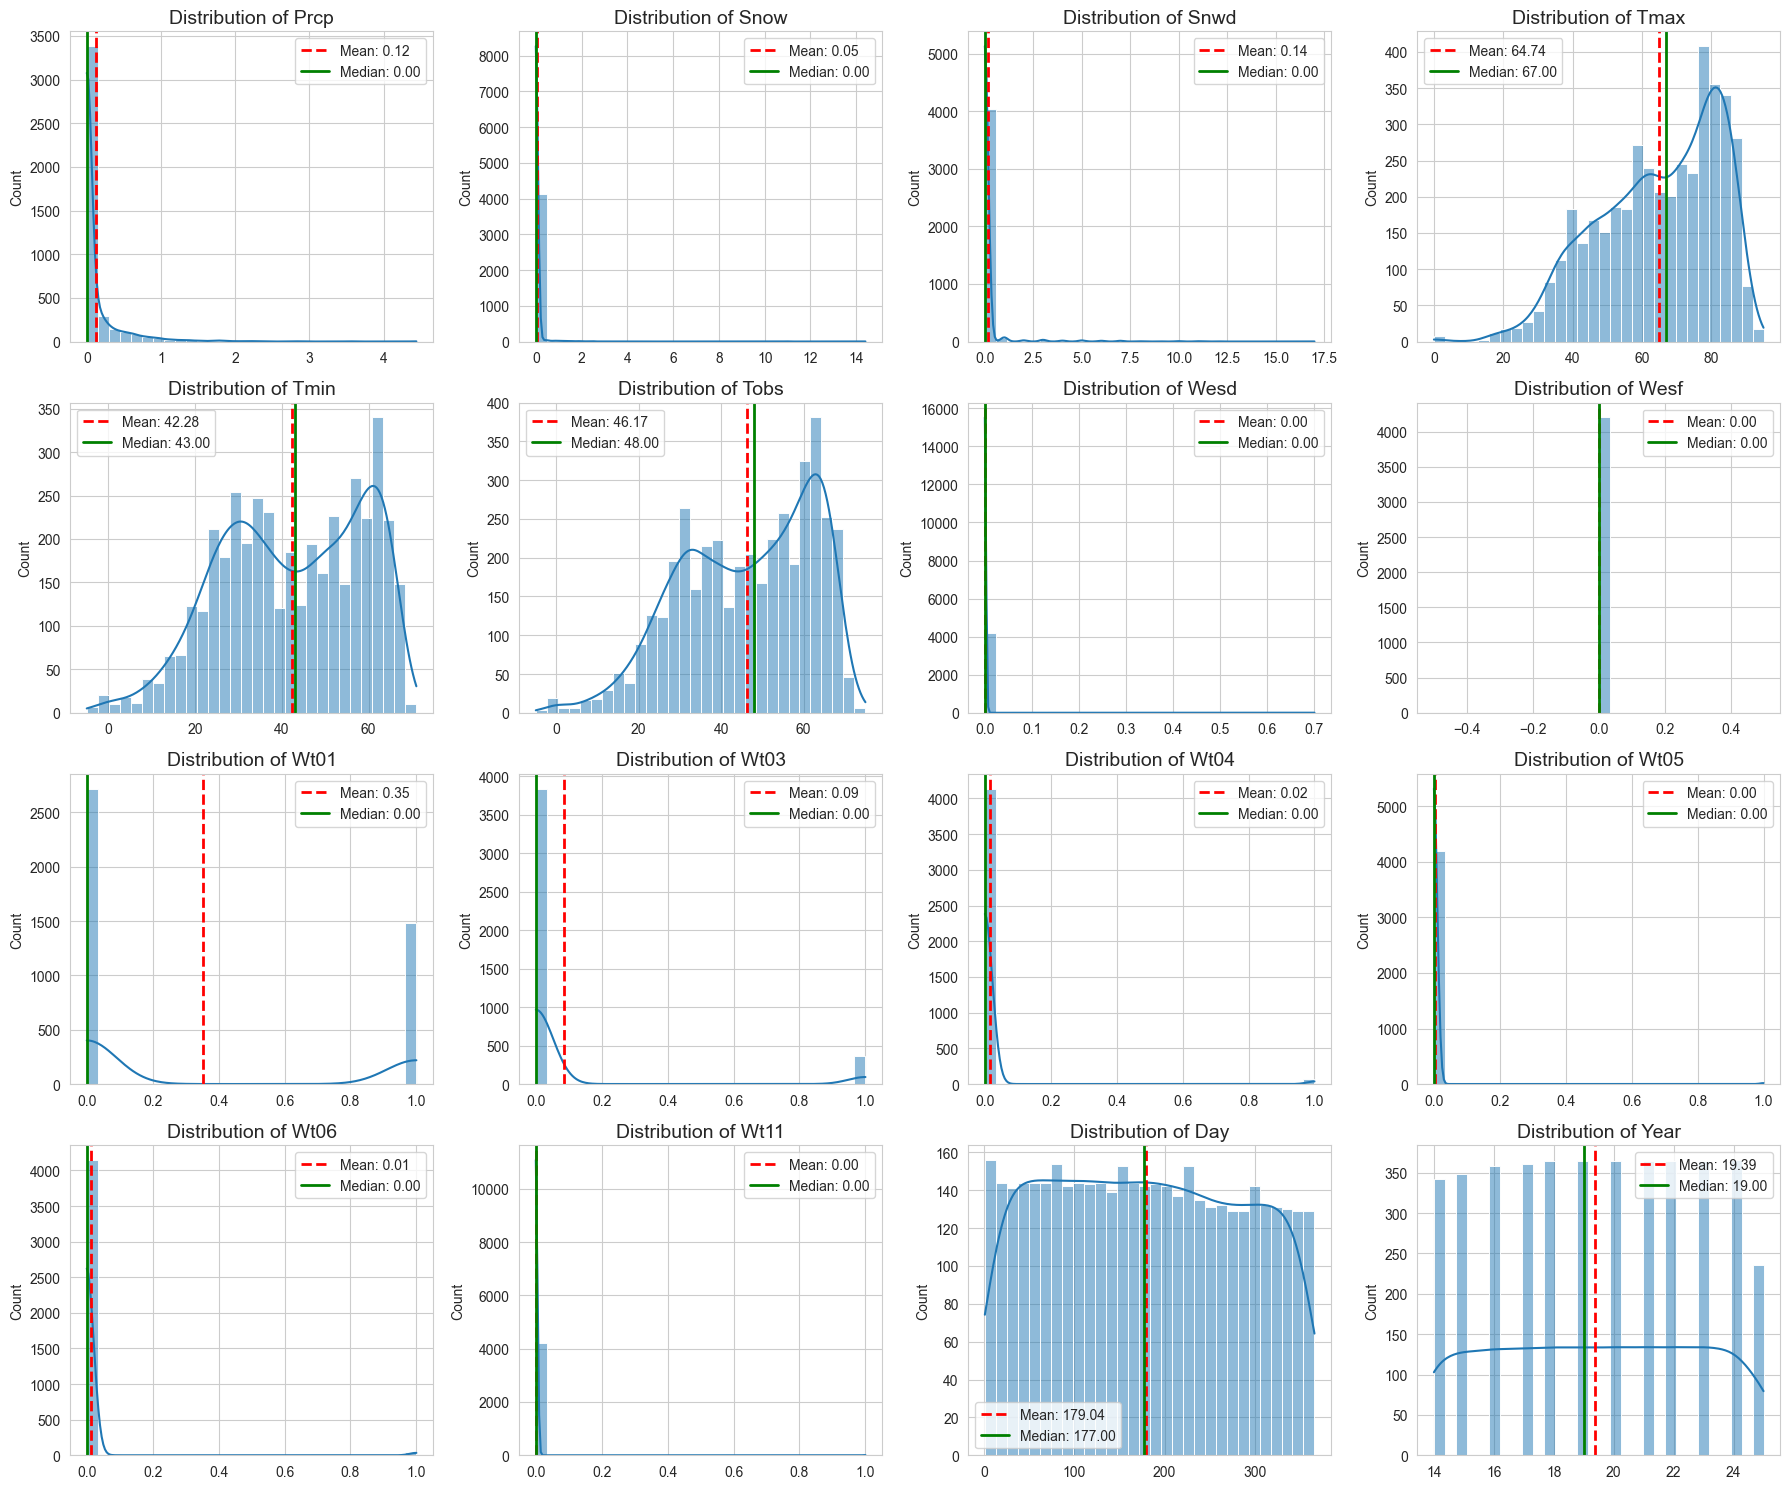

,Mean,Median,Std Dev,Min,Max,Range,Skewness,Outliers (>3σ)
Feature,,,,,,,,
Northern Cardinal,0.68,0.68,0.21,0.0,1.00,1.00,-0.55,65
Red-bellied Woodpecker,0.34,0.33,0.22,0.0,1.00,1.00,0.46,0
Red-winged Blackbird,0.16,0.07,0.20,0.0,1.00,1.00,1.20,33
Field Sparrow,0.09,0.00,0.13,0.0,1.00,1.00,2.29,78
Hairy Woodpecker,0.07,0.00,0.11,0.0,1.00,1.00,2.67,74
Eastern Meadowlark,0.05,0.00,0.09,0.0,1.00,1.00,3.23,93
Common Yellowthroat,0.03,0.00,0.08,0.0,1.00,1.00,3.91,114
Gadwall,0.02,0.00,0.07,0.0,1.00,1.00,4.60,109
Orchard Oriole,0.02,0.00,0.06,0.0,1.00,1.00,4.75,99


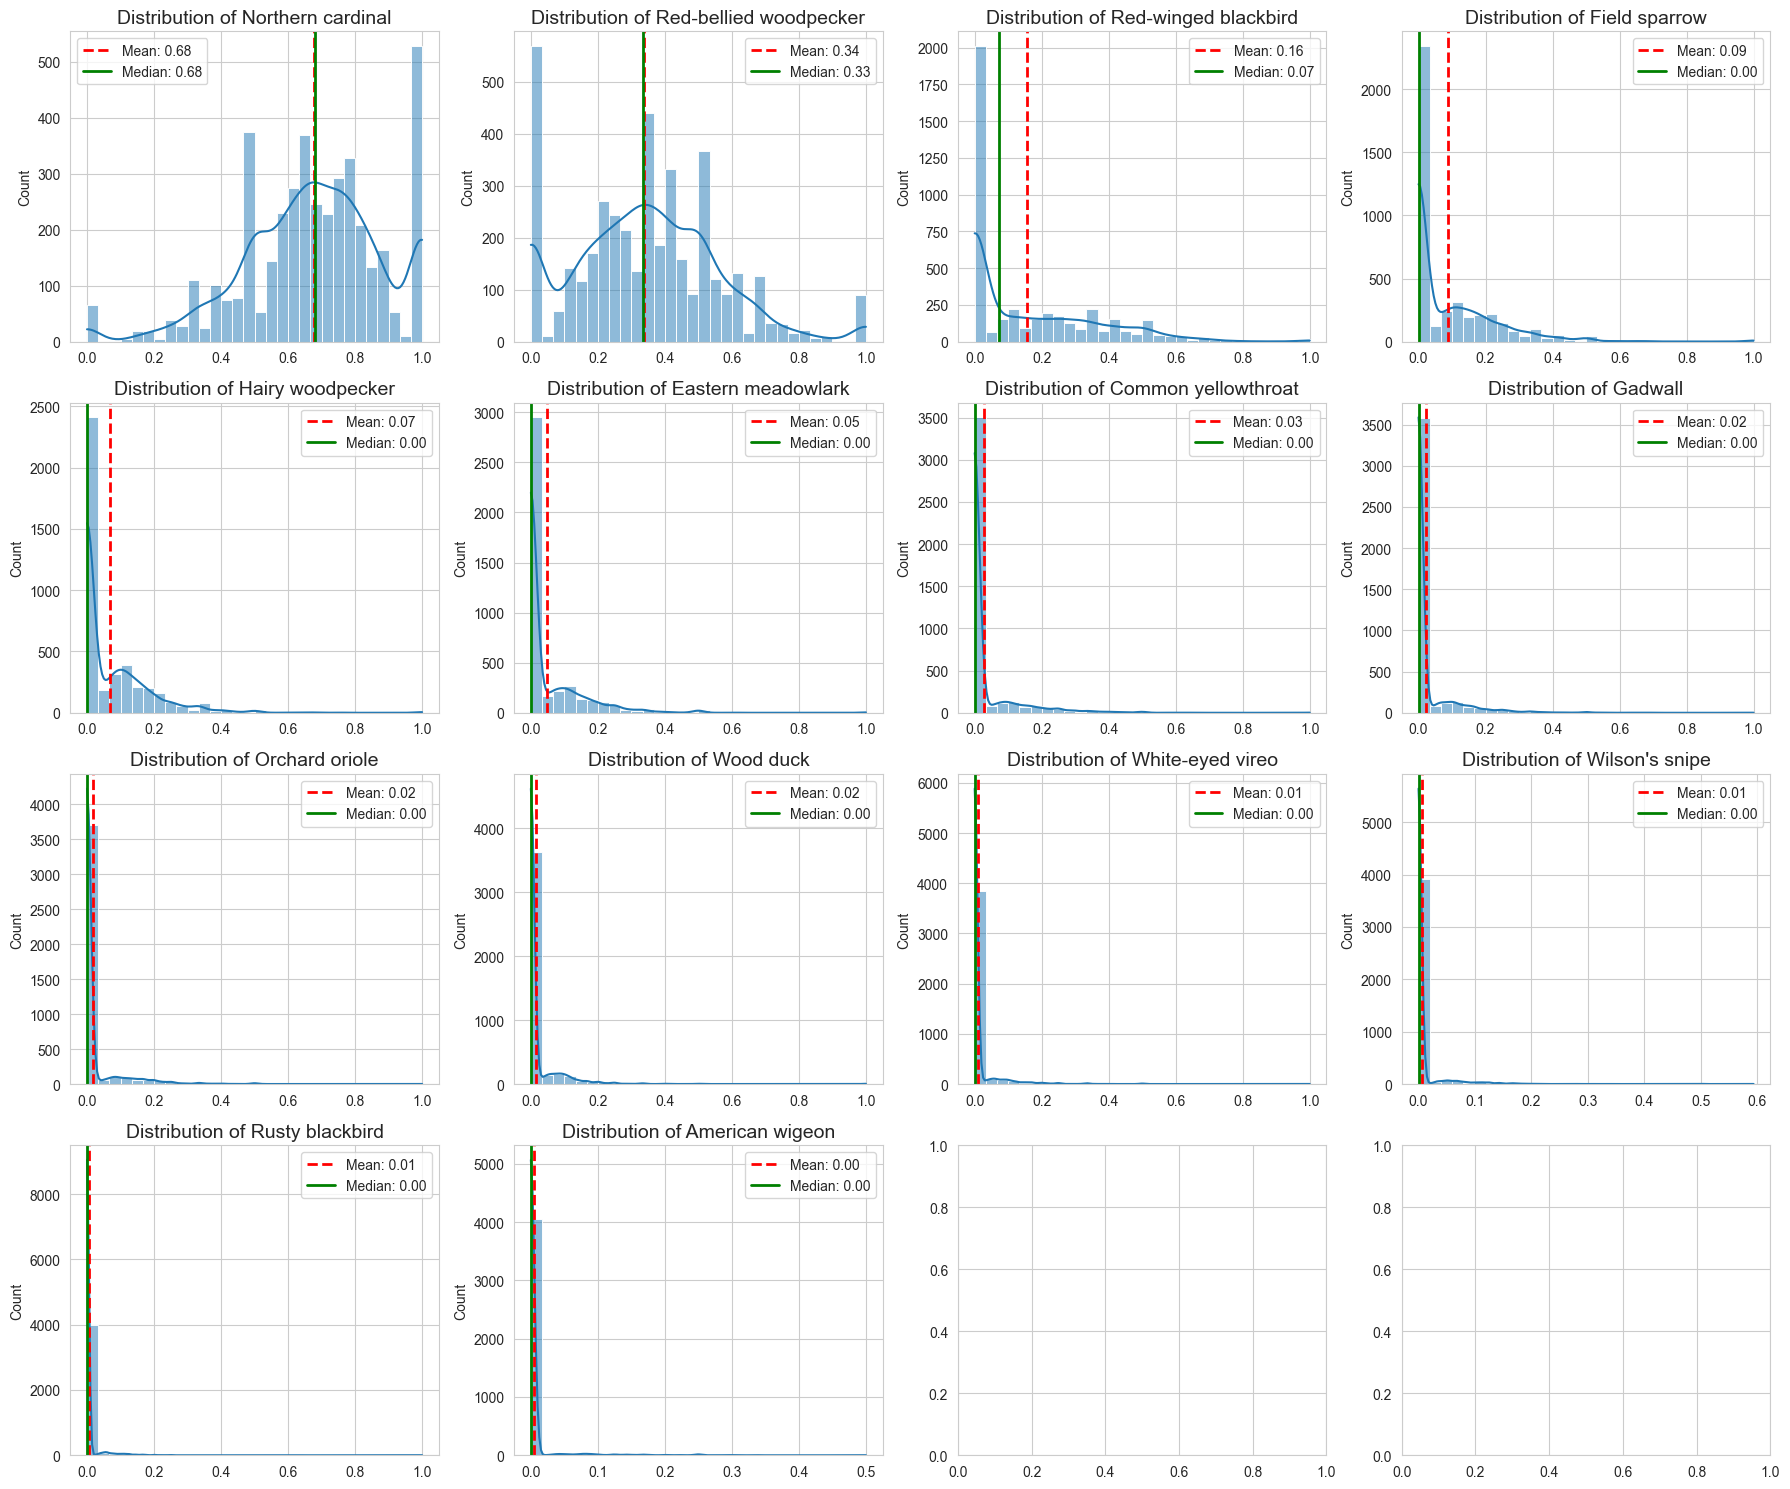

In [10]:
def create_quality_report(df, features):
    """Generates a data quality report for the specified features."""
    report = []
    for feature in features:
        data = df[feature].dropna()
        stats = {
            'Feature': feature,
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            'Range': data.max() - data.min(),
            'Skewness': data.skew(),
            'Outliers (>3σ)': len(data[np.abs(data - data.mean()) > 3 * data.std()])
        }
        report.append(stats)
    report_df = pd.DataFrame(report).set_index('Feature')
    display(report_df.round(2))

def visualize_distributions(df, features):
    """Creates distribution plots (histogram and KDE) for all specified features."""
    fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    axes = axes.ravel()
    for idx, feature in enumerate(features):
        ax = axes[idx]
        data = df[feature].dropna()
        sns.histplot(data, ax=ax, kde=True, bins=30)
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {data.mean():.2f}")
        ax.axvline(data.median(), color='green', linestyle='-', linewidth=2, label=f"Median: {data.median():.2f}")
        ax.set_title(f'Distribution of {feature.capitalize()}', fontsize=14)
        ax.set_xlabel('')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Run the analysis
create_quality_report(weather0_df, weather0_df.drop('DATE',axis=1).columns)
visualize_distributions(weather0_df, weather0_df.drop('DATE',axis=1).columns)
create_quality_report(sdailys_df, sdailys_df.drop('date',axis=1).columns[::11])
visualize_distributions(sdailys_df, sdailys_df.drop('date',axis=1).columns[::11])

### Normalize inputs

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
norm_weath_df = pd.DataFrame(scaler.fit_transform(weather0_df.drop('DATE',axis=1)), columns=weather0_df.drop('DATE',axis=1).columns)

# This feature is always zero
norm_weath_df.drop('WESF',axis=1,inplace=True)

display(norm_weath_df.tail())
# for index,row in dailys_df.iterrows():
#     if sum(row.drop('date')) != 0:
#         print(row)

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT11,DAY,YEAR
4197,-0.382948,-0.096256,-0.151542,0.944174,1.327440,1.118593,-0.023163,-0.738142,-0.306571,-0.124364,-0.055708,-0.113023,-0.026729,0.505462,1.675822
4198,0.653590,-0.096256,-0.151542,1.176510,1.327440,1.244047,-0.023163,-0.738142,-0.306571,-0.124364,-0.055708,-0.113023,-0.026729,0.515005,1.675822
4199,1.250385,-0.096256,-0.151542,0.944174,1.388560,1.181320,-0.023163,-0.738142,-0.306571,-0.124364,-0.055708,-0.113023,-0.026729,0.524549,1.675822
4200,-0.382948,-0.096256,-0.151542,0.595671,1.021838,0.804958,-0.023163,-0.738142,-0.306571,-0.124364,-0.055708,-0.113023,-0.026729,0.534092,1.675822
4201,-0.351538,-0.096256,-0.151542,0.653755,1.021838,1.055866,-0.023163,-0.738142,-0.306571,-0.124364,-0.055708,-0.113023,-0.026729,0.543636,1.675822


Some final data setup is required, including batching into training and testing sets

In [12]:
X = norm_weath_df
y = sdailys_df.drop('date',axis=1)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

print('done')

done


### Random forest 
Here we explore a random forest as an option for this regression problem. An experiment is performed varying the depth of trees and number of features shown to the model. 

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import time

feature_list = [0.2, 0.4, 0.6, 0.8, 1.0]
depth_list = [5, 10, 20, 40, 80, None]

time_out = np.zeros((len(feature_list), len(depth_list)))
train_out = np.zeros((len(feature_list), len(depth_list)))
test_out = np.zeros((len(feature_list), len(depth_list)))

print("features  depth      time       train      test")
for i,features in enumerate(feature_list):
    for j,depth in enumerate(depth_list):
        forest = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=depth, max_features=features)
        # Fit the model to the training data
        start_time = time.time()
        forest.fit(X_train, Y_train)
        end_time = time.time()
        train = forest.score(X_train, Y_train)
        test = forest.score(X_test, Y_test)
        runtime = (end_time - start_time)
        if depth is None:
            depth = "None"
        print(f" {features:^6}   {depth:^6}   {runtime:^6.6f}   {train:^6.6f}   {test:^6.6f}")
        time_out[i][j] = runtime
        train_out[i][j] = train
        test_out[i][j] = test
        

features  depth      time       train      test
  0.2       5      2.338346   0.145271   0.120596
  0.2       10     4.624142   0.420857   0.180336
  0.2       20     8.097343   0.874505   0.184202
  0.2       40     8.502068   0.886858   0.184967
  0.2       80     8.863365   0.886654   0.182488
  0.2      None    8.218075   0.885127   0.184908
  0.4       5      2.657660   0.187875   0.158364
  0.4       10     5.777784   0.504118   0.214859
  0.4       20     9.603105   0.886451   0.203790
  0.4       40     10.269762   0.889632   0.206350
  0.4       80     10.730263   0.888545   0.202211
  0.4      None    10.366773   0.890272   0.206540
  0.6       5      3.203734   0.203289   0.173296
  0.6       10     6.794661   0.525789   0.229321
  0.6       20     11.270223   0.887225   0.208557
  0.6       40     11.473908   0.889933   0.205627
  0.6       80     11.646667   0.889147   0.207253
  0.6      None    12.146032   0.890001   0.207788
  0.8       5      3.861489   0.214271   0.18

Some quick code to export the experiment's results

In [14]:
np.savetxt("output/time_out.csv", time_out, delimiter=",")
np.savetxt("output/train_out.csv", train_out, delimiter=",")
np.savetxt("output/test_out.csv", test_out, delimiter=",")
print('done')

done


### SVM
A preliminary single run of SVM, showing poor results. Future experiments will be run

In [15]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

# Initialize model with rbf kernel
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Adapt model to multi output and train        
start_time = time.time()
multi = MultiOutputRegressor(svr_model).fit(X_train, Y_train)
end_time = time.time()
print(f'Runtime (s): {end_time-start_time}')

# Predict on test data
print(f'R^2 on test set: {multi.score(X_test, Y_test)}')

Runtime (s): 44.149417877197266
R^2 on test set: -3.2016324431621355


### Feature Importance
Here we test the importance of various features to the trained model's accuracy. Note that these results are specifically in the context of the model we are using, and a better model may prioritize other features more

In [16]:
forest = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=10, max_features=0.8)
# Fit the model to the training data
forest.fit(X_train, Y_train)
train = forest.score(X_train, Y_train)
test = forest.score(X_test, Y_test)
print(f'Training R^2:{train}')
print(f'Test R^2:{test}')

Training R^2:0.5273778842436143
Test R^2:0.22595598086246443


In [20]:
from sklearn.inspection import permutation_importance
r = permutation_importance(forest, X_test, Y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{weather0_df.drop('DATE',axis=1).columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


WT11    0.398 +/- 0.010
DAY     0.126 +/- 0.005
TMIN    0.056 +/- 0.004
TMAX    0.038 +/- 0.004
TOBS    0.012 +/- 0.002
SNOW    0.001 +/- 0.000
SNWD    0.001 +/- 0.000


In [22]:
import pickle
with open("randomforest.pkl","wb") as outfile:
    pickle.dump(forest, outfile)